# Modelling ranges

## Trapezoidal distribution


As a minimal example, let's assume that we have datation "4th c. BC".
As a first step, we have to operationalize its start and stop points:

In [0]:
start = -400
stop = -301

 Further,  I assume that the the probability that the object emerged in 385 BC, 350 BC or 320 BC is **approximately equal** . 
At the same time, it is **less likely** that the  object emerged in the first or last decade of the century, since this would be probably coded in another way (e.g. "beginning of the 4th c. BC" etc.).

It seems that the best way how to model this is through a [trapezoidal distrubution](https://en.wikipedia.org/wiki/Trapezoidal_distribution).

In Python, trapezoidal distribution is implemented in SciPy library as [scipy.stats.trapz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trapz.html). 


In [0]:
from scipy.stats import trapz
import seaborn as sns

We will use this function as a core for our function optimized for working with date ranges

In [0]:
def dist_range(start, stop, size=1, bending_point_b=0.1):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  r = trapz.rvs(bending_point_b, 1-bending_point_b, size=size)
  duration = abs(start-stop)
  return int((r * duration) + start)

If we specify only start and end, it returns only one number. By default, the two bending points are configured to 0.1 and 0.9  of the duration of the function.

In [169]:
dist_range(101, 200) # * 100) + 100

114

This way we can produce a large amount of numbers for each date range in our dataset

In [0]:
raw_date = "4th c. BC"
start = -400
stop = -301
n_of_iterations = 5000
iters = trapezoid(start, stop, n_of_iterations)

For one date range, the resulting distrubution might be visualized by means of a histogram:

(-400.0, -301.0)

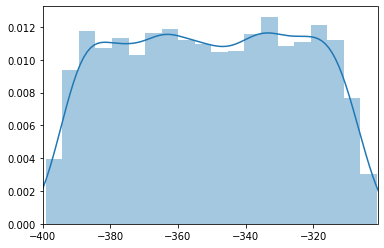

In [171]:
sns.distplot(iters, bins=20)
plt.xlim(start, stop)

# Modelling ante quem & post quem

A very common way of dating in our dataset is using **ante quem** (before that date) and **post quem** (after that date).

Again, here we have to ask about the shape of the distribution we want to model.

## a) Trapezoidal
One option is to approach it the same way as ranges, as a combination of uniform and triangular distribution. We can use our code for trapezoidal distrubution and just set up *a* = *b*, i.e. that the lower bound equals to the first bending point.  

In [0]:
def dist_ante_post(date, date_type, size=1, duration=100):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  if "post" in date_type:
    r = trapz.rvs(0, 0.50, size=size)
    return (r * duration) + date
  if "ante" in date_type:
    r = trapz.rvs(0.50, 1, size=size)
    return (r * duration) + date

Test with "post 250 AD"

In [174]:
dist_ante_post(250, "post")

array([298.69478634])

In [0]:
iters = dist_ante_post(250, "post", 5000)

(250.0, 350.0)

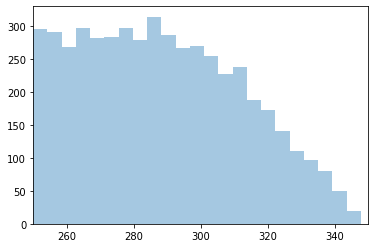

In [187]:
sns.distplot(iters, kde=False) # alternatively: hist=False
plt.xlim(250, 350)

## b) Half-normal distribution

Perhaps a better model would be a normal distribution with rather long tail



In [0]:
from scipy.stats import halfnorm

Here we can especially play with the `scale` parameter.



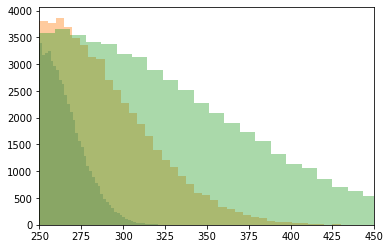

In [186]:
for scale in [20, 50, 100]:
  r = halfnorm.rvs(250, scale, 50000)
  sns.distplot(r, kde=False)
  plt.xlim(250, 450)

`scale`=50 appears to be very useful for applications where centuries are common, like PHI or EDH. So let's implement it to our model as default value.

In [0]:
def dist_ante_post(date, date_type, size=1, scale=50):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  if "post" in date_type:
    r = halfnorm.rvs(date, scale, size)
    return r.astype(int)
  if "ante" in date_type:
    r = halfnorm.rvs(scale=scale, size=size)
    return (date - r).astype(int)

In [164]:
# simple test with "post"
dist_ante_post(250, "post", 10)

array([292, 271, 306, 299, 289, 280, 265, 273, 268, 365])

In [181]:
# simple test with "ante"
dist_ante_post(250, "ante", 10)

array([218, 183, 124, 230, 183, 127, 242, 173, 227, 220])

Now we can test fully our ante quem

(1.0, 250.0)

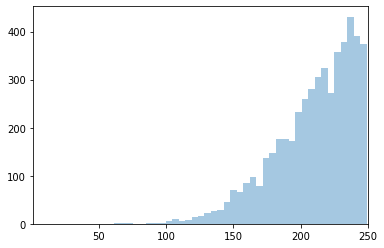

In [189]:
r = dist_ante_post(250, "ante", 5000) 
sns.distplot(r, kde=False)
plt.xlim(1, 250)